In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import npc_sessions
import polars as pl
import pandas as pd

In [2]:
units = npc_sessions.get_units_electrodes_spike_times('626791_2022-08-17').to_pandas()
units['device_name'].unique()

C:\Users\arjun.sridhar\source\repos\npc_lims\src\npc_lims\metadata\codeocean.py:125: UserWarning: There is more than one asset for session = '626791_2022-08-17'. Defaulting to most recent: ('ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels')
  warnings.warn(


array(['probeA', 'probeB', 'probeC', 'probeF'], dtype=object)

In [2]:
mean_waveforms = npc_sessions.get_mean_waveforms('662892_20230821')
sd_waveforms = npc_sessions.get_sd_waveforms('662892_20230821')

C:\Users\arjun.sridhar\source\repos\npc_lims\src\npc_lims\metadata\codeocean.py:125: UserWarning: There is more than one asset for session = '662892_2023-08-21'. Defaulting to most recent: ('ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels', 'ecephys_662892_2023-08-21_12-43-45_units_with_peak_channels')
  warnings.warn(


In [6]:
mean_waveforms[2].shape

(210, 384)

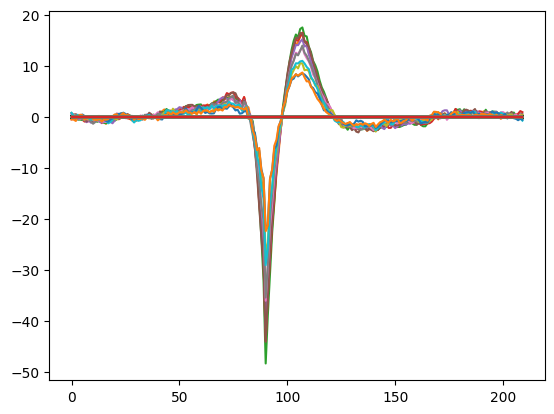

In [8]:
plt.plot(mean_waveforms[0])

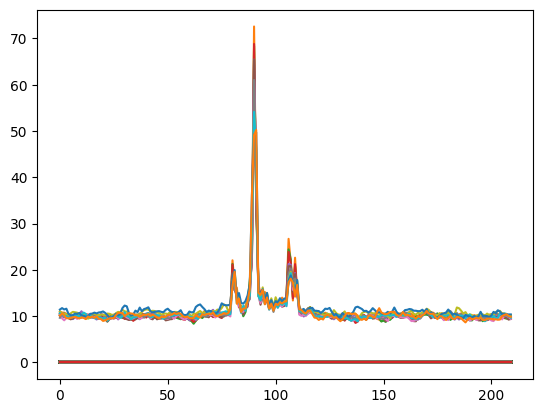

In [3]:
plt.plot(sd_waveforms[0])

In [ ]:
spike_times = npc_sessions.get_unit_spike_times_dict('636766_20230124', tuple(units['unit_name']))
spike_times

In [ ]:
len(units) == len(spike_times)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import npc_sessions
import polars as pl
import pandas as pd

sessions = []
for s in npc_sessions.tracked:
    try:
        result = s.is_uploaded
    except ValueError:       
        continue
    else:
        if not result:
            continue
    try:
        _ = npc_sessions.get_units_electrodes(s.session)
    except (FileNotFoundError, TypeError, ValueError) as exc:
        print(f'{s.session}: {exc!r}')
    else:
        print(f'{s.session}: units available')
        sessions.append(npc_sessions.Session(s.session))



session = next(s for s in sessions if s.id == '626791_2022-08-17')




stim = next(s for s in session.stim_data if 'DynamicRouting' in s)
trials = npc_sessions.DynamicRouting1(session.stim_data[stim], session.sync_data)
df = npc_sessions.get_units_electrodes_spike_times(session.id)

vis = df.filter(pl.col('structure_acronym').str.contains('VIS'))
aud = df.filter(pl.col('structure_acronym').str.starts_with('AUD'))

for spike_times in vis['spike_times']:
# spike_times = vis[random.randrange(len(vis))]['spike_times'][0]

    pad_start = .5
    pad_end = .5
    # align_on = 'response_window_start_time'
    align_on_time = 'stim_start_time'
    on = trials.to_dataframe().query('is_vis_stim')[align_on_time].values - pad_start
    off = pad_start + on + pad_end

    fig, ax = plt.subplots()
    ax.eventplot(
        [spike_times[a:b] - on[idx] - pad_start 
        for idx, (a, b)
        in enumerate(zip(np.searchsorted(spike_times, on), np.searchsorted(spike_times, off)))]
    )
    ax.axvline(0, color=[.8]*3, linestyle='--')
    ax.set(xlabel='time, s', ylabel='trials', xmargin=0, ymargin=0)
    ax2 = ax.secondary_xaxis('top')
    ax2.set(xticks=[0], xticklabels=[align_on_time]);
    plt.show()

In [6]:
def plot_unit_quality_metric_per_probe(units:pd.DataFrame, metric: str, session: str):
    probes = units['device_name'].unique()
    probe_index = 0

    for probe in probes:
        plt.figure(probe_index)
        units_probe_metric = units[units['device_name'] == probe][metric]
        units_probe_metric.hist()

        probe_index += 1
    
        plt.title(f'{session} {probe} {metric}')

c:\Users\arjun.sridhar\Anaconda3\envs\npc_sessions_env\lib\site-packages\npc_lims\metadata\codeocean.py:125: UserWarning: There is more than one asset for session = '668755_2023-08-28'. Defaulting to most recent: ('ecephys_668755_2023-08-28_13-06-40_units_with_peak_channels', 'ecephys_668755_2023-08-28_13-06-40_units_with_peak_channels')
  warnings.warn(


CCF annotations for 668755_2023-08-28 have not been uploaded to s3. Returning units without electrodes


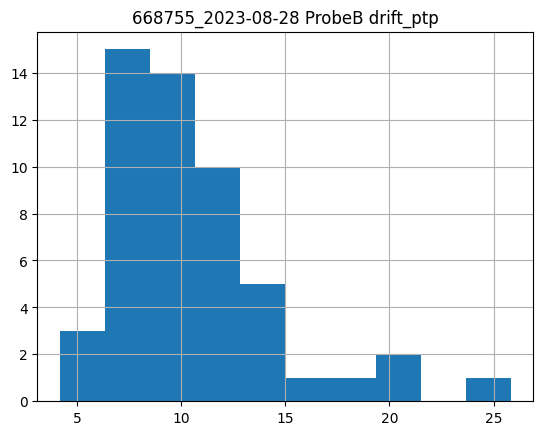

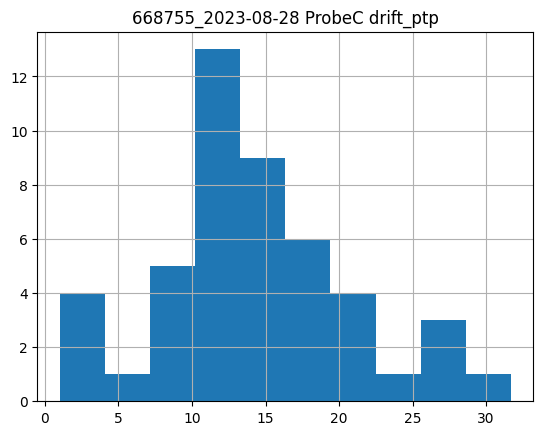

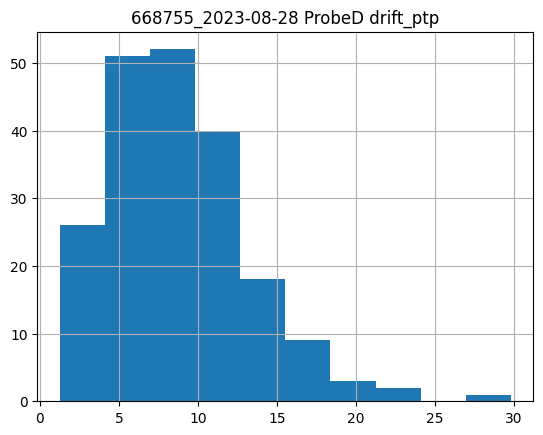

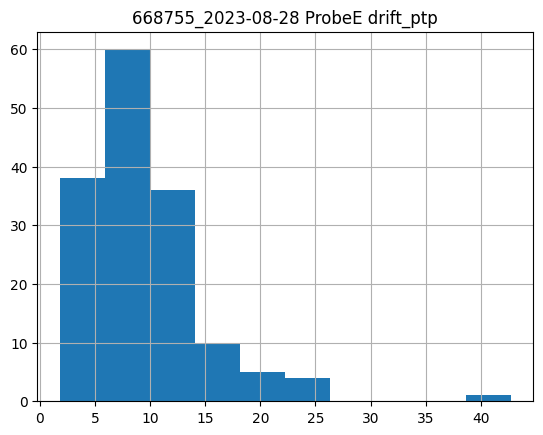

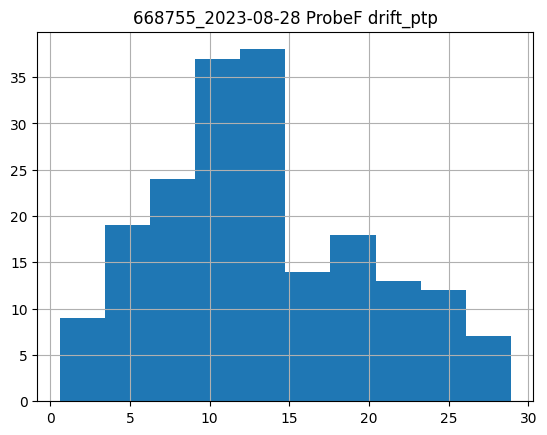

In [20]:
session = '668755_2023-08-28'
metric = 'drift_ptp'

units_spikes_electrodes = npc_sessions.get_units_electrodes_spike_times(session).to_pandas()
plot_unit_quality_metric_per_probe(units_spikes_electrodes, metric, session)

In [21]:
probe = 'ProbeD'
units_spike_electrodes_probe = units_spikes_electrodes[units_spikes_electrodes['device_name'] == probe]

Text(0, 0.5, 'Spike Count per 1 second bin')

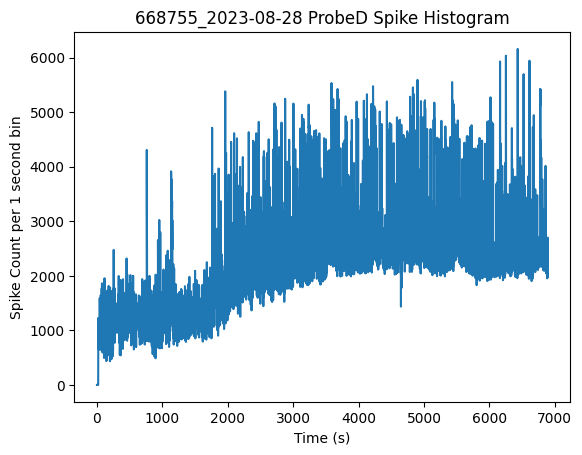

In [22]:
spike_times = units_spike_electrodes_probe['spike_times'].to_numpy()

hist, bins = npc_sessions.bin_spike_times(spike_times, bin_time=1)
plt.plot(hist)
plt.title(f'{session} {probe} Spike Histogram')
plt.xlabel('Time (s)')
plt.ylabel('Spike Count per 1 second bin')

342


Text(0, 0.5, 'Spike count per 1 second bin')

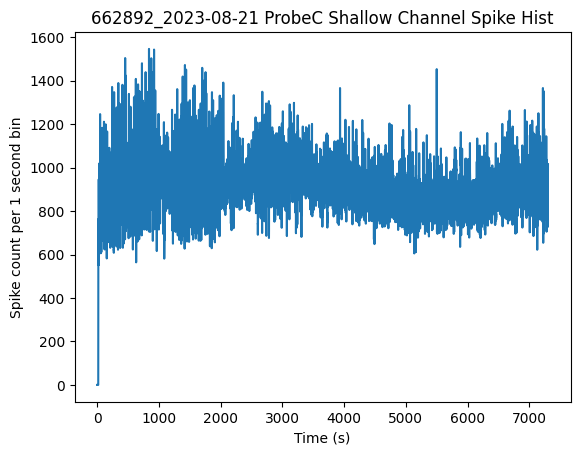

In [10]:
shallow_channel_spike_times = units_spike_electrodes_probe[units_spike_electrodes_probe['peak_channel'] > 200]['spike_times'].to_numpy()
print(len(shallow_channel_spike_times))

hist, bins = npc_sessions.bin_spike_times(shallow_channel_spike_times, bin_time=1)
plt.plot(hist)
plt.title(f'{session} {probe} Shallow Channel Spike Hist')
plt.xlabel('Time (s)')
plt.ylabel('Spike count per 1 second bin')

111


Text(0, 0.5, 'Spike count per 1 second bin')

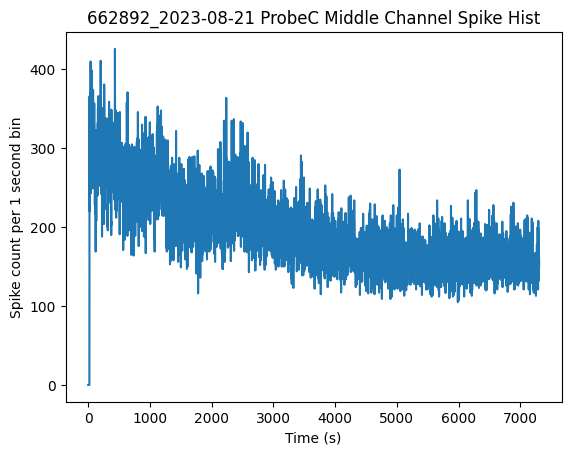

In [11]:
middle_channel_spike_times = units_spike_electrodes_probe[(units_spike_electrodes_probe['peak_channel'] <= 200) & 
    (units_spike_electrodes_probe['peak_channel'] > 100)]['spike_times'].to_numpy()
print(len(middle_channel_spike_times))

hist, bins = npc_sessions.bin_spike_times(middle_channel_spike_times, bin_time=1)
plt.plot(hist)
plt.title(f'{session} {probe} Middle Channel Spike Hist')
plt.xlabel('Time (s)')
plt.ylabel('Spike count per 1 second bin')

81


Text(0, 0.5, 'Spike count per 1 second bin')

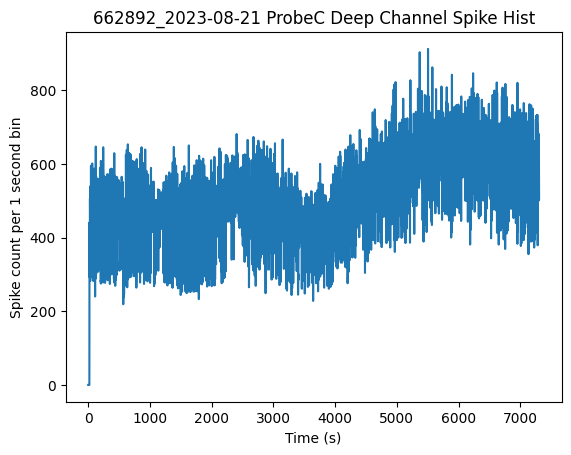

In [12]:
deep_channel_spike_times = units_spike_electrodes_probe[units_spike_electrodes_probe['peak_channel'] <= 100]['spike_times'].to_numpy()
print(len(deep_channel_spike_times))

hist, bins = npc_sessions.bin_spike_times(deep_channel_spike_times, bin_time=1)
plt.plot(hist)
plt.title(f'{session} {probe} Deep Channel Spike Hist')
plt.xlabel('Time (s)')
plt.ylabel('Spike count per 1 second bin')

In [13]:
units_pre_frontload = npc_sessions.get_units_electrodes_spike_times('626791_2022-08-17').to_pandas()

c:\Users\arjun.sridhar\Anaconda3\envs\npc_sessions_env\lib\site-packages\npc_lims\metadata\codeocean.py:125: UserWarning: There is more than one asset for session = '626791_2022-08-17'. Defaulting to most recent: ('ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels', 'ecephys_626791_2022-08-17_00-00-00_units_with_peak_channels')
  warnings.warn(


Text(0.5, 0, 'Drift')

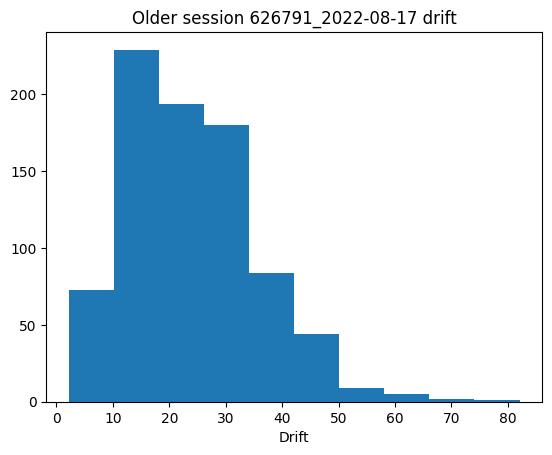

In [14]:
plt.hist(units_pre_frontload['drift_ptp'])
plt.title(f'Older session 626791_2022-08-17 drift')
plt.xlabel('Drift')

In [15]:
unit_frontload = npc_sessions.get_units_electrodes_spike_times('668755_2023-08-30').to_pandas()

c:\Users\arjun.sridhar\Anaconda3\envs\npc_sessions_env\lib\site-packages\npc_lims\metadata\codeocean.py:125: UserWarning: There is more than one asset for session = '668755_2023-08-30'. Defaulting to most recent: ('ecephys_668755_2023-08-30_12-36-35_units_with_peak_channels', 'ecephys_668755_2023-08-30_12-36-35_units_with_peak_channels')
  warnings.warn(


CCF annotations for 668755_2023-08-30 have not been uploaded to s3. Returning units without electrodes


Text(0.5, 0, 'Drift')

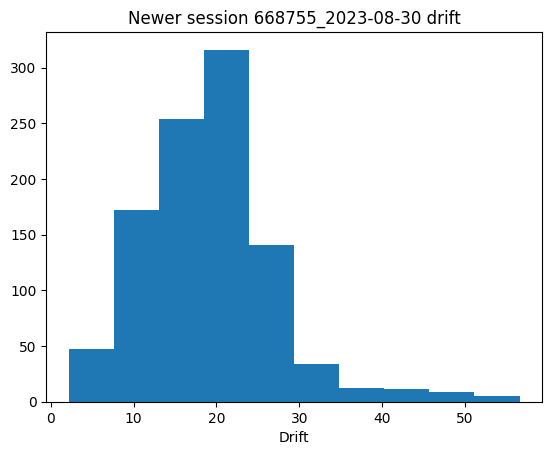

In [16]:
plt.hist(unit_frontload['drift_ptp'])
plt.title(f'Newer session 668755_2023-08-30 drift')
plt.xlabel('Drift')